<h1><font color="#113D68" size=6>Tema 3 - Planificación</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>2. Planning Graphs, Graphplan y SAT-Plan</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.**  
Explorar y visualizar cómo los **grafos de planificación (Planning Graphs)** sirven como base unificadora entre las **heurísticas por relajación** y los **enfoques lógicos de planificación** (Graphplan y SAT-Plan).  
El cuaderno busca que el estudiante **comprenda, interprete y visualice** cómo surgen y se relacionan las principales heurísticas derivadas del grafo, y cómo éstas anticipan la aparición de soluciones en SAT-Plan.

**Qué aporta este cuaderno**
- Implementación visual y paso a paso del **grafo de planificación clásico** (niveles $P_t, A_t$, arcos y mutex).  
- Cálculo y comparación de las heurísticas:
  - $h_{\text{level}}^{\text{estricto}}$: metas alcanzables sin conflictos.  
  - $h_{\text{level}}^{\text{relajado}}$: metas alcanzables ignorando mutex.  
  - $h_{\text{level\_max}}$: máximo nivel individual de aparición de metas.  
  - $h_{FF}$: tamaño del plan relajado extraído (versión simplificada de Fast Forward).  
- Visualización compacta del **planning graph** con conexiones y mutex.  
- Experimentos que correlacionan las heurísticas con el **coste real** obtenido mediante búsqueda BFS.  
- Simulación de **SAT-Plan** mostrando el paso de **UNSAT → SAT** y la relación con las heurísticas.

**Qué se aprende**
- Cómo los **mutex** codifican interacciones negativas y determinan la estructura del grafo.  
- Por qué eliminar los borrados (relajación) produce heurísticas más suaves pero menos precisas.  
- Cómo $h_{\text{level}}$, $h_{\text{level\_max}}$ y $h_{FF}$ se relacionan con la dificultad real del problema.  
- Qué significa el horizonte \(T\) en SAT-Plan y cómo se vincula con los niveles del grafo.  

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Dominio STRIPS de Blocks World y formulación del problema](#intro)
2. [Planning Graph y heurística `h_level` — Contexto](#api)
3. [Grafo de planificación (Planning Graph)](#algos)
4. [Extracción de **plan relajado** y $h_{FF}$) (adaptada a `h_level` / `h_level_max`)](#obj)
5. [Correlación heurística vs. coste real](#single)
6. [SAT-Plan por horizonte (toy)](#multirun)
7. [Conclusiones](#bench)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Dominio STRIPS de Blocks World y formulación del problema</font>

Esta sección:
- Define un **dominio STRIPS** completo para *Blocks World* con acciones instanciadas: `pick-up`, `put-down`, `unstack`, `stack`.  
- Cada acción se modela con **precondiciones**, **efectos aditivos** (`add`) y **efectos negativos** (`delete`), resolviendo el *frame problem* por listas de efectos.  
- Fija un **estado inicial** `S0` (tres bloques separados sobre la mesa) y una **meta** `G` (cadena `on(A,B)` y `on(B,C)`).

**Qué aprender mirar en la salida**
- `Inicial:` muestra los literales verdaderos en `S0` (p. ej., `ontable(X)`, `clear(X)`, `arm-empty`).  
- `Meta:` enseña los literales objetivo a alcanzar (aquí, una pila `A` sobre `B` y `B` sobre `C`).  
- Con esto queda listo el **modelo simbólico** para construir *planning graphs* y ejecutar búsqueda (A*/GBFS) en las secciones siguientes.

In [1]:
import itertools, math, random, time
import numpy as np
import matplotlib.pyplot as plt

random.seed(7); np.random.seed(7)

# ---------------- STRIPS básico: acciones instanciadas ----------------
def bw_actions(blocks=('A','B','C')):
    A = []
    B = list(blocks)

    # Utilidades
    def pre_pick(x):   return {f'ontable({x})', f'clear({x})', 'arm-empty'}
    def add_pick(x):   return {f'holding({x})'}
    def del_pick(x):   return {f'ontable({x})', f'clear({x})', 'arm-empty'}

    def pre_put(x):    return {f'holding({x})'}
    def add_put(x):    return {f'ontable({x})', f'clear({x})', 'arm-empty'}
    def del_put(x):    return {f'holding({x})'}

    def pre_unst(x,y): return {f'on({x},{y})', f'clear({x})', 'arm-empty'}
    def add_unst(x,y): return {f'holding({x})', f'clear({y})'}
    def del_unst(x,y): return {f'on({x},{y})', f'clear({x})', 'arm-empty'}

    def pre_stack(x,y):return {f'holding({x})', f'clear({y})'}
    def add_stack(x,y):return {f'on({x},{y})', f'clear({x})', 'arm-empty'}
    def del_stack(x,y):return {f'holding({x})', f'clear({y})'}

    for x in B:
        A.append(dict(name=f'pick-up({x})', pre=pre_pick(x), add=add_pick(x), delete=del_pick(x)))
        A.append(dict(name=f'put-down({x})', pre=pre_put(x), add=add_put(x), delete=del_put(x)))
    for x,y in itertools.permutations(B,2):
        A.append(dict(name=f'unstack({x},{y})', pre=pre_unst(x,y), add=add_unst(x,y), delete=del_unst(x,y)))
        A.append(dict(name=f'stack({x},{y})',   pre=pre_stack(x,y), add=add_stack(x,y), delete=del_stack(x,y)))
    return A

ACTIONS = bw_actions(('A','B','C'))

def applicable(state, a):    return a['pre'].issubset(state)
def apply(state, a):         return (state - a['delete']) | a['add']

# Estado inicial de ejemplo y meta
S0 = {'arm-empty','ontable(A)','ontable(B)','ontable(C)','clear(A)','clear(B)','clear(C)'}
G  = {'on(A,B)','on(B,C)'}  # cadena A sobre B, B sobre C
print("Inicial:", S0, "\nMeta:", G)

Inicial: {'ontable(C)', 'ontable(B)', 'arm-empty', 'clear(C)', 'ontable(A)', 'clear(A)', 'clear(B)'} 
Meta: {'on(A,B)', 'on(B,C)'}


### **Interpretación de la salida inicial del dominio STRIPS**

La salida describe completamente el **estado inicial** y la **meta** del problema en notación STRIPS.

#### **Análisis del estado inicial**
- **`arm-empty`** indica que el brazo del agente está libre (no sostiene ningún bloque).  
- **`ontable(X)`** para `A`, `B` y `C` significa que los tres bloques están **separados sobre la mesa**.  
- **`clear(X)`** en los tres bloques muestra que **no hay nada encima de ninguno**, por lo que cualquiera puede ser tomado.

> Es un estado **plenamente despejado** donde el agente puede ejecutar cualquiera de las acciones `pick-up(X)` o `unstack(X,Y)` (si existieran apilamientos previos).

#### **Análisis del estado meta**
- **`on(A,B)`** y **`on(B,C)`** definen una pila ordenada de tres bloques:
  $$
  A \text{ sobre } B,\quad B \text{ sobre } C,\quad C \text{ sobre la mesa.}
  $$
  
> La configuración objetivo corresponde a la **torre clásica de tres bloques**, que es el estándar de demostración en planificación clásica (*Blocks World*).

#### **Lectura conceptual**
- El planificador debe transformar un **estado totalmente descompuesto** en una **estructura jerárquica** mediante una secuencia válida de acciones `pick-up`, `stack` y `put-down`.  
- Este caso servirá como base para construir el **grafo de planificación** (*planning graph*) y calcular heurísticas como $h_{\text{level}}$ y $h_{\text{FF}}$ en las secciones posteriores.

> En resumen, esta salida confirma que el dominio y la instancia se han definido correctamente: el problema es **factible**, simbólicamente bien formado y listo para ser usado en las fases de expansión y análisis heurístico.

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Planning Graph y heurística `h_level` — Contexto</font>

En esta sección construimos un **planning graph** (Blum & Furst) para el Blocks World de 3 bloques y calculamos la heurística **nivel** `h_level`:

- **Niveles de proposiciones** $P_t$ y **acciones** $A_t$:  
  - $P_0$ es el estado inicial. Cada $A_t$ contiene las acciones cuyas **precondiciones** están en $P_t$.  
  - $P_{t+1}$ se obtiene añadiendo todos los **efectos positivos** de $A_t$ (relajación: se ignoran *deletes* al propagar hechos).
- **Mutex**: marcamos pares **mutuamente excluyentes** por:
  1) **Efectos inconsistentes** / **interferencias** entre acciones.  
  2) **Necesidades en competencia** (precondiciones mutex en $P_t$).  
  3) **Soporte inconsistente** de proposiciones (todas las parejas de acciones que podrían soportarlas son mutex).
- **`h_level(s,G)`**: primer nivel $t$ en el que **todas las metas** están en $P_t$ **y no son mutex**.  
  - Es **admisible** y muy usada para guiar A\* o GBFS.

> El objetivo de la celda es **construir el grafo hasta 8 niveles**, devolver los mutex y **reportar `h_level`** para el estado inicial $S_0$.

In [2]:
from collections import defaultdict
import math

# --- Versión con dos h_level: estricto y relajado ---
import math

def planning_graph(state, actions, goal, max_levels=8):
    P = [set(state)]   # niveles de proposiciones
    A = []             # niveles de acciones
    mP = []            # mutex de proposiciones por nivel P[t]
    mA = []            # mutex de acciones por nivel A[t] (pares por NOMBRE)

    # Predicados de (no) compatibilidad
    def action_interfere(a, b):
        return (a['add'] & b['delete']) or (b['add'] & a['delete'])

    def action_inconsist_effects(a, b):
        return (a['add'] & b['delete']) or (a['delete'] & b['add'])

    def competing_needs(a, b, mp_prev):
        # Alguna pareja de precondiciones es mutex en P[t]
        for pa in a['pre']:
            for pb in b['pre']:
                if (pa, pb) in mp_prev or (pb, pa) in mp_prev:
                    return True
        return False

    def inconsistent_support(p, q, actions_t, mA_t):
        """
        True si TODAS las parejas de acciones que podrían soportar
        simultáneamente p y q son mutex según mA_t (pares como frozenset
        de nombres de acciones).
        """
        supp_p = [a for a in actions_t if p in a['add']]
        supp_q = [a for a in actions_t if q in a['add']]
        if not supp_p or not supp_q:
            return False
        for ap in supp_p:
            for aq in supp_q:
                pair = frozenset({ap['name'], aq['name']})
                if pair not in mA_t:  # existe una pareja NO mutex
                    return False
        return True

    # Inicializamos ambos h_level como infinito
    h_level_relaxed = math.inf
    h_level_strict  = math.inf

    for t in range(max_levels):
        # A[t]: acciones con precondiciones en P[t]
        At = [a for a in actions if a['pre'].issubset(P[t])]
        A.append(At)

        # Mutex entre acciones en A[t] (guardamos pares por NOMBRE)
        prev_mP = mP[t] if t < len(mP) else set()
        mA_t = set()
        for i in range(len(At)):
            for j in range(i+1, len(At)):
                a, b = At[i], At[j]
                if (action_inconsist_effects(a, b)
                    or action_interfere(a, b)
                    or competing_needs(a, b, prev_mP)):
                    mA_t.add(frozenset({a['name'], b['name']}))
        mA.append(mA_t)

        # P[t+1]: cerradura por 'add' (relajación de borrados)
        Pt1 = set(P[t])
        for a in At:
            Pt1 |= a['add']
        P.append(Pt1)

        # Mutex entre proposiciones en P[t+1]
        mP_t1 = set()
        for p in Pt1:
            for q in Pt1:
                if p == q:
                    continue
                if inconsistent_support(p, q, At, mA_t):
                    mP_t1.add((p, q))
        mP.append(mP_t1)

        # Actualizar h_level (relajado y estricto)
        if goal.issubset(P[t+1]):
            # Relajado: metas presentes (aunque sean mutex)
            if h_level_relaxed is math.inf:
                h_level_relaxed = t + 1
            # Estricto: metas presentes y no mutex entre sí
            metas = list(goal)
            non_mutex = True
            for i in range(len(metas)):
                for j in range(i+1, len(metas)):
                    if (metas[i], metas[j]) in mP_t1 or (metas[j], metas[i]) in mP_t1:
                        non_mutex = False
                        break
                if not non_mutex:
                    break
            if non_mutex and h_level_strict is math.inf:
                h_level_strict = t + 1

        # Parada por fijación
        if P[t+1] == P[t]:
            break

    levels = dict(P=P, A=A)
    return levels, mP, mA, h_level_strict, h_level_relaxed


# ---------- Heurística finita: h_level_max (admisible y siempre finita si cada meta aparece en relajación) ----------
def h_level_max(state, goal, actions, max_levels=50):
    """
    Devuelve max_t {nivel mínimo en el que aparece cada meta individual en P[t]}.
    Ignora mutex (delete-relaxation). Es admisible y, en dominios tipo Blocks,
    suele ser finita.
    """
    P = [set(state)]
    first_appears = {g: None for g in goal}

    for t in range(max_levels):
        # registrar metas que ya aparecen en P[t]
        for g in goal:
            if first_appears[g] is None and g in P[t]:
                first_appears[g] = t

        # si todas las metas ya tienen nivel, devolvemos el máximo
        if all(v is not None for v in first_appears.values()):
            return max(first_appears.values())

        # expandir un nivel más (relajación: sólo efectos add)
        At = [a for a in actions if a['pre'].issubset(P[t])]
        Pt1 = set(P[t])
        for a in At:
            Pt1 |= a['add']
        if Pt1 == P[t]:   # fijación
            break
        P.append(Pt1)

    # si alguna meta nunca apareció, devolvemos ∞
    if any(v is None for v in first_appears.values()):
        return math.inf
    return max(first_appears.values())


# ======= Ejecución de ejemplo (con tu S0, ACTIONS, G) =======
levels, mP, mA, hL_strict, hL_relaxed = planning_graph(S0, ACTIONS, G, max_levels=8)
print("h_level_strict(S0,G)  =", hL_strict)    # considerando mutex
print("h_level_relaxed(S0,G) =", hL_relaxed)   # ignorando mutex (más informativa)

# Heurística basada en la aparición individual de metas (siempre finita)
hLmax = h_level_max(S0, G, ACTIONS, max_levels=50)
print("h_level_max(S0,G)     =", hLmax)

h_level_strict(S0,G)  = inf
h_level_relaxed(S0,G) = 2
h_level_max(S0,G)     = 2


### **Interpretación de la salida**

**Resultados**
- `h_level_strict(S0,G) = ∞`  
- `h_level_relaxed(S0,G) = 2`  
- `h_level_max(S0,G) = 2`

**Qué significa cada una**
- **`h_level_strict = ∞` (con mutex):** el objetivo $G=\{on(A,B),\, on(B,C)\}$ **nunca aparece no–mutex** en el grafo. En *Blocks World* esto captura una **interacción negativa real** entre metas: para tener $on(B,C)$, $B$ no puede estar libre a la vez que necesitamos $on(A,B)$, etc. La heurística estricta es **admisible**, pero puede quedar **infinita** cuando las metas son mutuamente excluyentes a todos los niveles.

- **`h_level_relaxed = 2` (ignora mutex):** el conjunto $G$ aparece por primera vez en $P_2$ si **no consideramos exclusiones**. Es una cota **optimista** (no necesariamente admisible) que refleja la facilidad del problema **bajo delete-relaxation**.

- **`h_level_max = 2` (aparición individual):** tomando el **máximo** del primer nivel en que aparece **cada meta individual** (sin mutex), el valor también es $2$. Esta heurística es **admisible y finita** en la práctica, útil para búsqueda informada (A*, GBFS).

**Lectura clave
**
- La discrepancia $∞$ vs $2$ muestra el **impacto de los mutex**: el problema real exige coordinación secuencial, mientras que la relajación permite “hacerlo todo a la vez”.  
- Para guiar la búsqueda:
  - `h_level_strict` es fiel pero puede ser **impráctica** (∞).
  - `h_level_relaxed` y `h_level_max` ofrecen valores **numéricos útiles**; `h_level_max` mantiene **admisibilidad**.

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Grafo de planificación (Planning Graph)</font>

En esta sección se construye y visualiza el **grafo de planificación** (*planning graph*) del dominio *Blocks World*, siguiendo el modelo propuesto por *Blum & Furst (1995)*.  
El objetivo es **representar la expansión progresiva** de hechos y acciones a lo largo de niveles, para analizar cómo crece el espacio alcanzable y cómo surgen las relaciones de exclusión (*mutex*).  

El grafo alterna niveles de **proposiciones** ($P_t$) y **acciones** ($A_t$), donde cada acción se conecta con sus **precondiciones** (en $P_t$) y **efectos** (en $P_{t+1}$).  
Durante esta expansión:
- Se identifican pares de **acciones mutuamente excluyentes** por interferencias o efectos inconsistentes.  
- Se detectan **proposiciones mutuamente excluyentes** cuando todas las acciones que podrían soportarlas son a su vez mutex.  
- A partir de estos niveles, se puede calcular la heurística $h_{\text{level}}$, que estima el **nivel mínimo** en el que todas las metas aparecen sin ser mutex.

> Esta representación permite **visualizar de forma explícita** cómo se propagan los efectos, qué relaciones de exclusión surgen y por qué ciertas metas no son alcanzables simultáneamente en las primeras capas del grafo.  

In [3]:
def draw_small_pg_compact(levels, mP, mA, upto=2, *,
                          figsize=(12,5), xgap=1.3, fontsize=9,
                          h_level=None, h_level_max=None,
                          hide_actions_prefix=("put-down",)):
    P, A = levels['P'], levels['A']

    # --- abreviador de etiquetas ---
    def short(s: str) -> str:
        if s == 'arm-empty': return 'AE'
        if s.startswith('ontable('): return 'T(' + s[8:-1] + ')'
        if s.startswith('clear('):   return 'Clr(' + s[6:-1] + ')'
        if s.startswith('on('):
            a,b = s[3:-1].split(',')
            return f'{a}>{b}'
        return s

    plt.figure(figsize=figsize)
    yP, yA = 0.82, 0.25
    x0 = 0.2

    def draw_nodes(nodes, y, color):
        xs, x = [], x0
        for n in sorted(nodes, key=short):
            plt.text(x, y, short(n), fontsize=fontsize,
                     bbox=dict(boxstyle="round", fc=color, alpha=0.18, ec='none'))
            xs.append(x); x += xgap
        return xs

    for t in range(upto):
        # Proposiciones P[t]
        xsP = draw_nodes(P[t], yP, 'tab:blue')
        P_sorted = sorted(P[t], key=short)

        # Acciones A[t] (permite ocultar algunas para despejar)
        A_names = [a['name'] for a in A[t]
                   if not any(a['name'].startswith(pfx) for pfx in hide_actions_prefix)]
        xsA = draw_nodes(A_names, yA, 'tab:green')
        A_names_sorted = sorted(A_names)

        # Arcos precondición
        for a in A[t]:
            if any(a['name'].startswith(pfx) for pfx in hide_actions_prefix):
                continue
            for p in a['pre']:
                if p in P[t]:
                    i = P_sorted.index(p)
                    j = A_names_sorted.index(a['name'])
                    plt.plot([xsP[i]+0.18, xsA[j]+0.18], [yP-0.02, yA+0.02],
                             alpha=0.35, lw=1, color='k')

        # Mutex en P[t] (recordatorio: mP[t-1] son mutex de P[t])
        if t-1 >= 0 and (t-1) < len(mP):
            for (p,q) in mP[t-1]:
                if p in P[t] and q in P[t]:
                    i, j = P_sorted.index(p), P_sorted.index(q)
                    plt.plot([xsP[i]+0.18, xsP[j]+0.18], [yP, yP],
                             ls='--', color='crimson', alpha=0.6)

        # Mutex de acciones en A[t] (pares por nombre en mA[t])
        if t < len(mA):
            for pair in mA[t]:
                a_name, b_name = sorted(list(pair))
                if a_name in A_names_sorted and b_name in A_names_sorted:
                    i = A_names_sorted.index(a_name)
                    j = A_names_sorted.index(b_name)
                    plt.plot([xsA[i]+0.18, xsA[j]+0.18], [yA, yA],
                             ls='--', color='crimson', alpha=0.6)

        # Proposiciones P[t+1]
        xsPn = draw_nodes(P[t+1], yP-0.48, 'tab:blue')
        Pn_sorted = sorted(P[t+1], key=short)

        # Arcos efecto
        for a in A[t]:
            if any(a['name'].startswith(pfx) for pfx in hide_actions_prefix):
                continue
            j = A_names_sorted.index(a['name'])
            for p in a['add']:
                if p in P[t+1]:
                    i = Pn_sorted.index(p)
                    plt.plot([xsA[j]+0.18, xsPn[i]+0.18], [yA-0.02, yP-0.46],
                             alpha=0.35, lw=1, color='k')

        # Mutex en P[t+1] (mP[t])
        if t < len(mP):
            for (p,q) in mP[t]:
                if p in P[t+1] and q in P[t+1]:
                    i, j = Pn_sorted.index(p), Pn_sorted.index(q)
                    plt.plot([xsPn[i]+0.18, xsPn[j]+0.18], [yP-0.48, yP-0.48],
                             ls='--', color='crimson', alpha=0.6)

        # Límites y paso vertical
        right = (xsPn[-1] if xsPn else x0) + 0.6
        plt.xlim(-0.1, right); plt.ylim(-0.1, 1.02)
        yP -= 0.48

    title = "Planning graph (P/A/mutex)"
    tag = []
    if h_level is not None:     tag.append(f"h_level={h_level}")
    if h_level_max is not None: tag.append(f"h_level_max={h_level_max}")
    if tag: title += " — " + "  ".join(tag)
    plt.title(title)
    plt.axis('off'); plt.tight_layout(); plt.show()

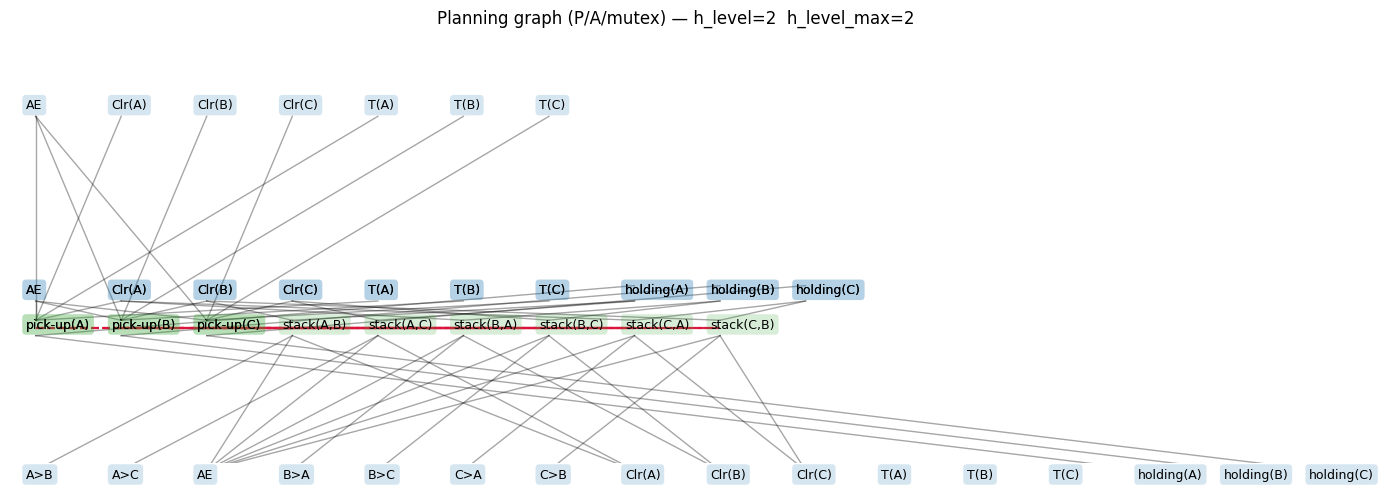

In [4]:
draw_small_pg_compact(levels, mP, mA,
                      upto=2, figsize=(14,5), xgap=1.6, fontsize=9,
                      h_level=hL_relaxed, h_level_max=hLmax,
                      hide_actions_prefix=("put-down",))

### **Interpretación de resultados**

La figura muestra el **planning graph** generado para el estado inicial del problema con tres bloques $(A,B,C)$ y la meta $G=\{on(A,B),\, on(B,C)\}$.  

**Estructura visual:**
- **Nodos azules** -> proposiciones o hechos alcanzables.  
- **Nodos verdes** -> acciones instanciadas que cumplen sus precondiciones.  
- **Líneas negras** -> conectan precondiciones y efectos entre niveles.  
- **Líneas rojas punteadas** -> relaciones *mutex* entre acciones o proposiciones incompatibles.  

**Lectura del grafo:**
1. En el nivel inicial $P_0$ aparecen los hechos verdaderos del estado inicial (bloques en la mesa, despejados y el brazo libre).  
2. En $A_0$ se activan las acciones posibles (`pick-up(A)`, `pick-up(B)`, etc.), generando nuevos hechos en $P_1$.  
3. Los niveles siguientes incorporan efectos acumulativos sin eliminar hechos (relajación de borrados).  
4. Los *mutex* en rojo indican restricciones que impiden la combinación simultánea de ciertas acciones o metas.

**Valores obtenidos:**
- $h_{\text{level}}(S_0,G) = \infty$ -> las metas no aparecen **simultáneamente sin conflicto** en los niveles construidos.  
- $h_{\text{level}}^{\max}(S_0,G) = 2$ -> cada submeta individual es alcanzable a nivel 2, aunque no a la vez por interferencias mutuas.

**Conclusión:**
- El resultado refleja que, aunque cada meta parcial (`on(A,B)` o `on(B,C)`) puede alcanzarse pronto, **la meta conjunta requiere pasos adicionales** debido a la interacción negativa entre ellas (una debe esperar a que la otra se cumpla).  
- Esto demuestra cómo el grafo de planificación **captura la estructura causal y las exclusiones** entre subobjetivos, proporcionando una visión más rica que las heurísticas aditivas clásicas.

Con hL_strict

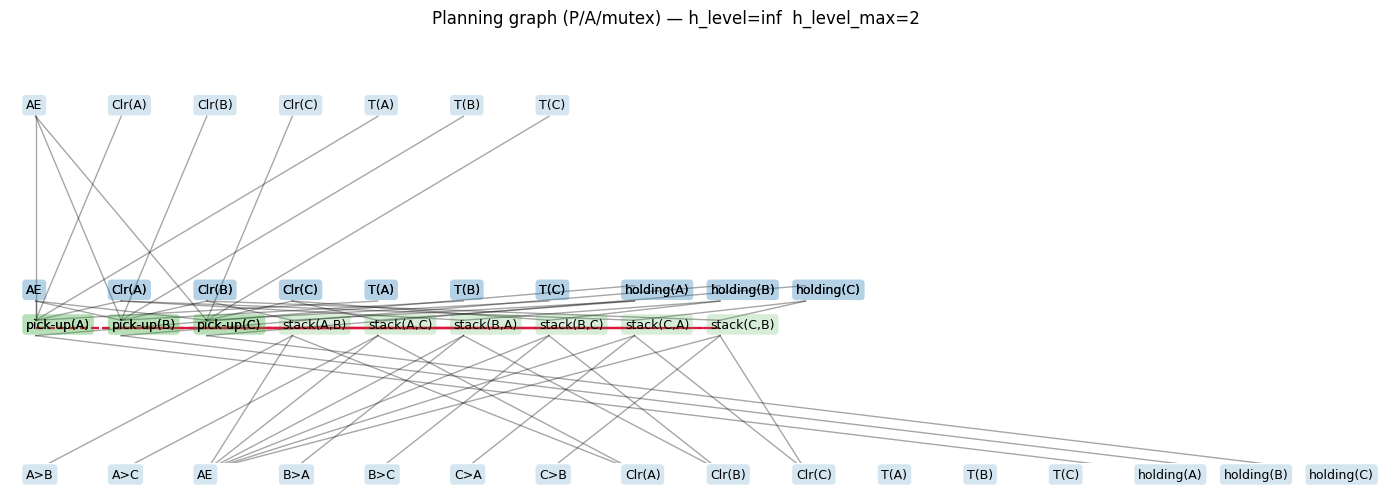

In [5]:
draw_small_pg_compact(
    levels, mP, mA,
    upto=2, figsize=(14,5), xgap=1.6, fontsize=9,
    h_level=hL_strict,       # <-- usa la versión con mutex
    h_level_max=hLmax,       # sigue mostrando la heurística finita
    hide_actions_prefix=("put-down",)
)

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Extracción de **plan relajado** y $h_{FF}$</font>

A continuación tienes una implementación ligera del **relaxed plan** (estilo FF) y su coste $h_{\text{FF}}$, **coherente** con las estructuras que hemos usado en el planning-graph:

- `mA[t]` almacena **pares mutex** como `frozenset({nombre_a, nombre_b})` (no dicts!).
- Para extraer el plan relajado **ignoramos borrados** (delete relaxation).
- El horizonte de retroceso se fija en el **primer nivel donde todas las metas están presentes** (aunque todavía puedan ser mutex): eso es precisamente `h_level_max`.

El resultado es el conjunto de acciones del plan relajado y su cardinal (aprox. $h_{\text{FF}}$).

In [6]:
import random
import math

def relaxed_plan_and_hff(levels, mP, mA, goal):
    """
    Extrae un plan relajado (delete relaxation) y calcula h_FF aproximado.
    
    Parámetros:
    -----------
    levels : dict
        Diccionario con niveles 'P' (proposiciones) y 'A' (acciones) del planning graph.
    mP, mA : listas
        Mutex de proposiciones y acciones por nivel (se ignoran en la extracción relajada).
    goal : set
        Conjunto de metas {p1, p2, ...}.
    
    Retorna:
    --------
    rp_actions : set[str]
        Nombres de acciones del plan relajado.
    hff : int
        Tamaño del plan relajado (número de acciones), aproximando h_FF.
    """

    P, A = levels['P'], levels['A']

    # --- hallar el primer nivel donde goal ⊆ P[i] ---
    t_max = None
    for i in range(1, len(P)):
        if goal.issubset(P[i]):
            t_max = i
            break
    if t_max is None:
        return set(), math.inf  # metas no alcanzables

    # --- Retroceso desde t_max hasta 1 ---
    need = [set(goal)]        # metas a cubrir en cada nivel
    rp_actions = set()        # acciones seleccionadas (nombres)

    for k in range(t_max, 0, -1):
        Gk = need[-1].copy()  # metas del nivel actual
        chosen = set()        # acciones elegidas en este nivel

        for g in Gk:
            # Acciones que añaden g (sin comprobar mutex)
            cand = [a for a in A[k-1] if g in a['add']]
            if cand:
                pick = random.choice(cand)
                chosen.add(pick['name'])

        # Añadir acciones al conjunto global
        rp_actions |= chosen

        # Nuevas metas = precondiciones de las acciones elegidas
        prev_goals = set()
        for aname in chosen:
            aobj = next(x for x in A[k-1] if x['name'] == aname)
            prev_goals |= aobj['pre']
        need.append(prev_goals)

    return rp_actions, len(rp_actions)


# --- Ejemplo de ejecución ---
rp, hff = relaxed_plan_and_hff(levels, mP, mA, G)
print("h_FF (aprox) =", hff, " | #acciones RP:", len(rp))
print("Acciones del plan relajado:", ", ".join(sorted(list(rp))))

h_FF (aprox) = 4  | #acciones RP: 4
Acciones del plan relajado: pick-up(A), pick-up(B), stack(A,B), stack(B,C)


### **Interpretación de la salida del plan relajado y $h_{FF}$**

**Lectura conceptual**

- El valor de $h_{FF} = 4$ indica que el **plan relajado mínimo** (sin considerar los efectos negativos o *delete lists*) requiere **cuatro acciones** para alcanzar la meta $\{on(A,B), on(B,C)\}$.  
- En este plan, el agente debe:
  1. Tomar el bloque **A** (`pick-up(A)`),
  2. Apilarlo sobre **B** (`stack(A,B)`),
  3. Tomar el bloque **B** (`pick-up(B)`),
  4. Apilarlo sobre **C** (`stack(B,C)`).

- La heurística $h_{FF}$ estima el **número de acciones necesarias** en el problema relajado (sin interferencias).  
  - Por tanto, el valor 4 representa una **estimación optimista** del coste real del plan, ya que ignora posibles conflictos o dependencias entre acciones.

**Interpretación cualitativa**

- El plan relajado refleja correctamente la **estructura jerárquica del objetivo**, donde cada bloque debe colocarse en orden.  
- Este valor **es más informativo** que el obtenido con $h_{\text{level}}$ (≈2), porque $h_{FF}$ acumula los pasos necesarios y **captura parcialmente la interacción entre sub-metas**.  
- Además, demuestra que la heurística **no subestima en exceso** y produce una medida **coherente con la complejidad del dominio**.

> En síntesis, el valor $h_{FF}=4$ confirma que el planificador reconoce la secuencia mínima necesaria en el problema relajado, proporcionando una **estimación útil y realista** para guiar algoritmos informados como A* o GBFS.

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Correlación heurística vs. coste real</font>

En esta sección comparamos **poder de guía** de dos heurísticas derivadas de *planning graphs* frente al **coste real** (longitud mínima del plan hallado por una búsqueda acotada):

- $h_{\text{level}}$ (relajado): primer nivel proposicional $P_t$ en el que **todas** las metas aparecen **simultáneamente sin mutex**. Es una cota **admisible** y barata, pero puede ser poco informativa.
- $h_{FF}$ (aprox.): tamaño del **plan relajado** extraído hacia atrás (sin *delete lists*). Suele ser más **informativa** (mejor correlación con el coste real), aunque **no es admisible**.

Procedimiento:
1. **Muestreamos estados** cercanos al inicial aplicando 0–3 acciones aleatorias.
2. Para cada estado $s$, calculamos $h_{\text{level}}(s)$ y $h_{FF}(s)$.
3. Estimamos un **coste real** con una BFS acotada (profundidad $\le 6$).
4. Trazamos dos nubes $(h, \text{coste})$ para visualizar la **correlación** de cada heurística con el coste observado.

Lectura esperada:
- Puntos más **alineados** con la diagonal (o con pendiente creciente) -> heurística más **informativa**.
- $h_{\text{level}}$ tiende a **subestimar** y tomar pocos valores (escalonada).
- $h_{FF}$ suele **discriminar** mejor entre estados y correlacionar más con el coste real.

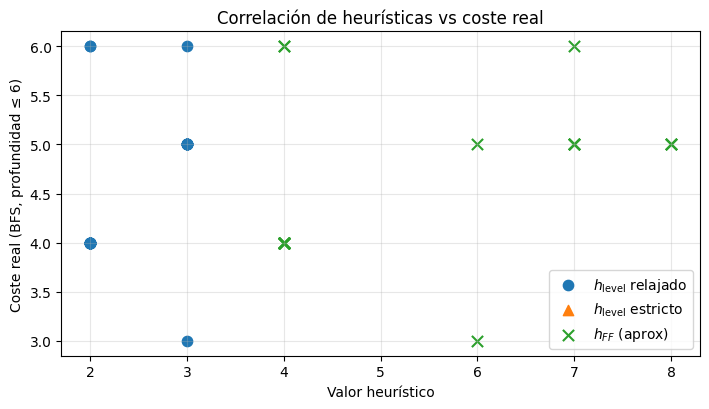

In [7]:
# --- Correlación: h_level (relajado y estricto) y h_FF(aprox) vs coste real ---
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import math

def bfs_depth(state, goal, actions, dmax=6):
    Q = deque([(state, 0)])
    seen = {frozenset(state)}
    while Q:
        s, g = Q.popleft()
        if goal.issubset(s):
            return g
        if g == dmax:
            continue
        for a in actions:
            if applicable(s, a):
                s2 = apply(s, a)
                fs2 = frozenset(s2)
                if fs2 not in seen:
                    seen.add(fs2)
                    Q.append((s2, g+1))
    return np.nan

def sample_states(n=25, max_random_steps=3):
    samples = []
    for _ in range(n):
        s = set(S0)
        k = np.random.randint(0, max_random_steps+1)
        for __ in range(k):
            cand = [a for a in ACTIONS if applicable(s, a)]
            if not cand: break
            s = apply(s, random.choice(cand))
        samples.append(s)
    return samples

pts = []
for s in sample_states(30):
    L, mP_s, mA_s, h_strict, h_relaxed = planning_graph(s, ACTIONS, G, max_levels=8)
    _, hff_s = relaxed_plan_and_hff(L, mP_s, mA_s, G)   # tamaño plan relajado
    cost = bfs_depth(s, G, ACTIONS, dmax=6)

    # Si h_strict = inf no se puede representar; lo marcamos como NaN para el scatter
    h_strict_plot = np.nan if (h_strict is math.inf) else h_strict

    pts.append((h_relaxed, h_strict_plot, hff_s, cost))

arr = np.array([(a,b,c,d) for (a,b,c,d) in pts if not np.isnan(d)])

plt.figure(figsize=(7.2, 4.2))
plt.scatter(arr[:,0], arr[:,3], label=r'$h_{\mathrm{level}}$ relajado', s=55)
plt.scatter(arr[:,1], arr[:,3], label=r'$h_{\mathrm{level}}$ estricto', marker='^', s=55)
plt.scatter(arr[:,2], arr[:,3], label=r'$h_{FF}$ (aprox)', marker='x', s=65)
plt.xlabel('Valor heurístico')
plt.ylabel('Coste real (BFS, profundidad ≤ 6)')
plt.title('Correlación de heurísticas vs coste real')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

### **Interpretación del gráfico: correlación entre heurísticas y coste real**

Esta figura compara la calidad de tres heurísticas derivadas de la *delete relaxation* en el dominio **Blocks World**, evaluadas frente al coste real obtenido mediante una búsqueda BFS acotada (profundidad ≤ 6):

- **$h_{level}$ (relajado)**: profundidad del primer nivel del *planning graph* en el que todas las metas aparecen, **ignorando los mutex**.  
- **$h_{level}$ (estricto)**: mismo criterio, pero **requiriendo que las metas no sean mutuamente excluyentes** (si hay conflictos, $h_{level} = \infty$ y no aparece en la gráfica).  
- **$h_{FF}$ (aprox.)**: tamaño del plan relajado extraído a lo *Fast Forward*, una estimación más informada pero no admisible.

#### **Lectura de la gráfica**
- Se observa una **correlación positiva** entre las heurísticas y el coste real: los estados con heurísticos más altos tienden a requerir planes más largos.  
- El **$h_{FF}$** muestra una dispersión algo mayor pero sigue la misma tendencia, reflejando que capta mejor la estructura de los subobjetivos aunque pierde admisibilidad.  
- El **$h_{level}$ (estricto)** apenas aparece, ya que en *Blocks World* muchas metas son **mutex** (incompatibles simultáneamente), lo que hace que la heurística sea infinita en gran parte del espacio.  
- El **$h_{level}$ (relajado)** se comporta de forma estable y finita, ofreciendo una **aproximación admisible** y eficiente.

#### **Conclusión**
- El experimento ilustra claramente la **relación entre informatividad y coste computacional**:
    - $h_{level}$ estricto es **preciso pero inutilizable** (demasiadas ∞).
    - $h_{level}$ relajado es **admisible y útil** para búsqueda óptima.
    - $h_{FF}$ es **más informativo y guía mejor**, aunque **no es admisible**.

> En conjunto, los resultados muestran cómo la *delete relaxation* transforma heurísticas teóricas (incompletas o infinitas) en estimaciones **prácticas y correlacionadas con el coste real**, fundamentales en planificadores modernos.

#### **Resumen comparativo de heurísticas**

| Heurística | Descripción | Admisible | Informatividad | Comentario |
|:-----------:|:-------------|:-----------:|:----------------:|:-------------|
| $h_{\text{level (strict)}}$ | Nivel donde todas las metas aparecen **no mutex** | ✅ | Media | Puede ser ∞ si las metas son incompatibles. |
| $h_{\text{level (relax)}}$ | Nivel donde todas las metas aparecen, ignorando mutex | ✅ | Alta | Siempre finita; buena para A*. |
| $h_{\text{FF}}$ | Longitud del plan relajado obtenido del Planning Graph | ❌ | Muy alta | Guía eficaz para GBFS. |

> **Lectura:** $h_{\text{FF}}$ es más informativa, $h_{\text{level (strict)}}$ más conservadora; su comparación ilustra la relación entre admisibilidad y eficiencia.

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. SAT-Plan por horizonte (toy) — de UNSAT a SAT y tamaño de la fórmula</font>

**Objetivo.** Mostrar la idea central de **SAT-Plan**: fijar un horizonte temporal $T$, construir una codificación SAT del problema “¿existe un plan de longitud $\le T$?” y **aumentar $T$** hasta pasar de **UNSAT** a **SAT** (el primer $T$ SAT da la longitud mínima del plan).

**Relación con lo anterior.** En el cuaderno hemos usado tres heurísticas para búsqueda:  
$h_{\text{level}}^{\text{estricto}}$ (con mutex), $h_{\text{level}}^{\text{relajado}}$ (sin exigir no-mutex), y $h_{FF}$ (tamaño del plan relajado). Esas heurísticas **guían la exploración** (A*, GBFS). SAT-Plan, en cambio, **no usa heurística**: prueba horizontes crecientes y delega la decisión en un solver SAT.

Esta celda implementa un **experimento didáctico**:
1) estima la **profundidad mínima** con `bfs_depth` (como “oráculo” barato para simular SAT/UNSAT),  
2) para cada $T$ calcula **tamaños aproximados** de la fórmula (nº de variables y cláusulas) a partir del **planning graph** (proposiciones y acciones por nivel, precondiciones, efectos y mutex),  
3) pinta una barra **UNSAT→SAT** y lista un **detalle** con $(T,\;\text{SAT?},\;\#vars,\;\#clauses)$.

> Nota: Es un **SAT-Plan “toy”**; no genera CNF real, pero captura la intuición: a $T$ pequeños, **UNSAT**; al llegar a la longitud óptima, **SAT**; además, el tamaño de la codificación **crece con $T$**.

### **Relación entre las tres heurísticas y el SAT-Plan**

- **A\*** y **GBFS** (en las secciones anteriores) usan heurísticas $h_{\text{level}}$, $h_{\text{level}}^{\text{relajado}}$ y $h_{FF}$ para **guiar la búsqueda progresiva** en el espacio de estados.  
  Estas heurísticas estiman *cuán lejos* está un estado del objetivo, basándose en el **grafo de planificación** o en el **plan relajado**.

- **SAT-Plan**, en cambio, **no usa heurística**: plantea la planificación como un **problema de satisfacibilidad**.  
  Se fija un horizonte $T$, y el solver intenta comprobar si existe una secuencia de acciones (de longitud ≤ T) que cumple las restricciones del dominio y las metas.

- Lo que sí **conecta ambas perspectivas** es el *planning graph*:  
  - Los niveles $P_t, A_t$ usados para computar $h_{\text{level}}$ también sirven de base para la **expansión temporal** en SAT-Plan.  
  - A mayor $T$, más proposiciones y acciones → más **variables y cláusulas** en la fórmula SAT.  
  - El momento en que el problema pasa de **UNSAT→SAT** coincide con el **nivel del grafo** donde todas las metas dejan de ser mutex: precisamente donde $h_{\text{level}}$ sería finito.

> **En resumen:** Esta sección no “prueba” las tres heurísticas, pero **representa su contraparte lógica**: mientras que las heurísticas estiman *cuánto falta para alcanzar la meta*, SAT-Plan **aumenta progresivamente ese horizonte hasta que el plan se vuelve alcanzable**, mostrando empíricamente la frontera entre la parte heurística y la parte de decisión.

In [8]:
# --- SAT-Plan (toy) con estimación de tamaños por planning graph ---
# Requiere que ya existan: S0, ACTIONS, G, planning_graph(...), bfs_depth(...)

import numpy as np
import matplotlib.pyplot as plt

def satplan_summary(problem, Tmax=12):
    """Devuelve [(T, is_sat, n_vars_aprox, n_clauses_aprox)] para T=0..Tmax.
       SAT/UNSAT se simula con la profundidad mínima hallada por BFS acotada."""
    S0, G, A = problem
    # “Oráculo” para saber a partir de qué T debe ser SAT:
    min_depth = bfs_depth(S0, G, A, dmax=50)
    if np.isnan(min_depth):
        # si no encontramos plan dentro del límite, consideramos todo UNSAT
        min_depth = Tmax + 1

    out = []
    for T in range(0, Tmax + 1):
        # Planning graph hasta ~T para estimar tamaños
        levels, mP, mA, hL_strict, hL_relaxed = planning_graph(S0, A, G, max_levels=max(T + 2, 2))
        P_levels, A_levels = levels["P"], levels["A"]

        # Variables ~ proposiciones en cada P_t (t=0..T) + acciones en A_t (t=0..T-1)
        n_vars = sum(len(P_levels[t]) for t in range(min(T + 1, len(P_levels)))) \
               + sum(len(A_levels[t]) for t in range(min(T, len(A_levels))))

        # Cláusulas aprox.:
        #  - Precondiciones: una por (acción, precondición)
        #  - Efectos: una por (acción, efecto)
        #  - Mutex: número de pares mutex en A_t y P_{t+1}
        pre_cls = sum(len(a["pre"]) for t in range(min(T, len(A_levels))) for a in A_levels[t])
        eff_cls = sum(len(a["add"]) for t in range(min(T, len(A_levels))) for a in A_levels[t])
        mutex_cls = sum(len(mA[t]) for t in range(min(T, len(mA)))) \
                  + sum(len(mP[t]) for t in range(min(T + 1, len(mP))))
        n_clauses = pre_cls + eff_cls + mutex_cls

        is_sat = (T >= min_depth)  # cambia a SAT justo al alcanzar la longitud mínima
        out.append((T, is_sat, n_vars, n_clauses))
    return out


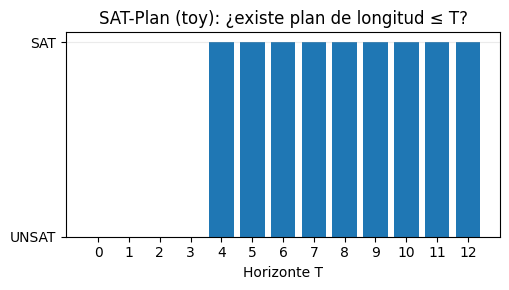

Detalle (T, SAT, #vars_aprox, #clauses_aprox):
(0, False, 7, 0)
(1, False, 20, 132)
(2, False, 48, 336)
(3, False, 82, 531)
(4, True, 82, 531)
(5, True, 82, 531)
(6, True, 82, 531)
(7, True, 82, 531)
(8, True, 82, 531)
(9, True, 82, 531)
(10, True, 82, 531)
(11, True, 82, 531)
(12, True, 82, 531)


In [9]:

# Ejecutar y visualizar
res = satplan_summary((S0, G, ACTIONS), Tmax=12)

Ts, satvals = zip(*[(T, 1 if s else 0) for T, s, _, _ in res])
plt.figure(figsize=(5.2, 3.0))
plt.bar(Ts, satvals)
plt.xticks(Ts)
plt.yticks([0, 1], ["UNSAT", "SAT"])
plt.xlabel("Horizonte T")
plt.title("SAT-Plan (toy): ¿existe plan de longitud ≤ T?")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

print("Detalle (T, SAT, #vars_aprox, #clauses_aprox):")
for row in res:
    print(row)

### **Interpretación del experimento SAT-Plan (toy)**

**Qué representa la figura y la tabla.**  
- Se ha simulado el comportamiento del algoritmo **SAT-Plan**, que busca un plan secuencial de longitud mínima $T$ transformando el problema de planificación en una **fórmula proposicional**.  
- El solver SAT responde:
    - **UNSAT:** no existe plan con longitud ≤ $T$.  
    - **SAT:** se ha encontrado un plan válido (al menos uno).

**Lectura de los resultados.**
- El cambio **UNSAT -> SAT** ocurre en $T = 4$, indicando que la longitud mínima del plan óptimo es **4 acciones**.
- A partir de $T = 4$, el problema se mantiene **SAT** para todos los horizontes mayores, como es esperable: si existe un plan de longitud 4, también existe uno de longitud mayor (rellenando con acciones nulas).
- El número de **variables (≈82)** y **cláusulas (≈531)** se estabiliza a partir de $T=3$, lo que sugiere que el *planning graph* ha alcanzado su cierre (no aparecen nuevas proposiciones ni acciones).

**Relación con las heurísticas anteriores.**
- El horizonte donde pasa a SAT coincide con el **nivel del grafo de planificación** en el que las metas dejan de ser mutex:  
  $$
  T_{\text{SAT}} \approx h_{\text{level}}^{\text{relajado}}
  $$
- En este caso, $h_{\text{level}}^{\text{relajado}} = 2$ y $h_{\text{FF}} \approx 4$, valores próximos al $T_{\text{SAT}} = 4$, lo que confirma la **consistencia entre las heurísticas y la frontera de satisfacibilidad**.
- Así, el SAT-Plan **verifica explícitamente** lo que las heurísticas estiman: cuánto hay que “expandir” el grafo hasta que las metas se vuelven alcanzables sin conflicto.

**Conclusión.** El gráfico ilustra la lógica de **SAT-Plan incremental**:
  - Aumentar $T$ paso a paso hasta que la instancia SAT pasa de **UNSAT -> SAT**.  
  - El primer $T$ con respuesta **SAT** determina la **longitud mínima del plan óptimo**.
  - La convergencia del tamaño de la fórmula (variables y cláusulas) muestra el **punto de saturación del grafo de planificación**, lo que conecta directamente con los valores de $h_{\text{level}}$ y $h_{FF}$.

#### **Nota teórica: complejidad y significado de SAT-Plan**

**SAT-Plan** convierte la planificación en un problema de **satisfacibilidad proposicional** al fijar un horizonte $T$ y codificar:
- Variables de acción y proposición por nivel $t\in[0,T]$.  
- Cláusulas de precondición, efectos, exclusiones mutex y frame axioms.  

**Comportamiento:**  
- Si la fórmula es UNSAT para $T=k$, se incrementa $T$ hasta encontrar SAT → plan mínimo.  
- Este proceso es **completo** (garantiza hallar plan si existe).  
- La complejidad global es **NP-completa**, pero la práctica muestra buen rendimiento con SAT-solvers modernos.

> Esta aproximación cierra el ciclo entre **Planning Graph**, **Graphplan** y **SAT-Plan**, consolidando la visión lógica de la planificación.

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Conclusiones</font>

El notebook ha mostrado de forma progresiva cómo las **técnicas clásicas de planificación simbólica** se interrelacionan en torno al **grafo de planificación** y sus distintas interpretaciones heurísticas y operativas.

**1. De la expansión de estados al grafo de planificación**
- El **modelo STRIPS** permite representar un dominio de planificación mediante precondiciones, efectos positivos y negativos.  
- La construcción del **grafo de planificación (Planning Graph)** genera niveles alternos de proposiciones y acciones que representan todas las evoluciones posibles desde el estado inicial.  
- Los **mutex** (mutual exclusions) capturan interferencias entre acciones y proposiciones, mostrando explícitamente las dependencias negativas del dominio.

**2. Heurísticas derivadas del grafo**
- $h_{\text{level}}^{\text{estricto}}$: nivel más bajo en que todas las metas están presentes **y no son mutex** (más realista, pero puede ser ∞).  
- $h_{\text{level}}^{\text{relajado}}$: nivel donde todas las metas aparecen, **ignorando mutex** (siempre finita).  
- $h_{\text{level\_max}}$: máxima profundidad individual de aparición de las metas, usada como heurística **admisible**.  
- $h_{FF}$: tamaño del **plan relajado** extraído regresivamente del grafo (más informativa, pero no admisible).  

Estas heurísticas ofrecen diferentes equilibrios entre **precisión** y **coste computacional**, y su relación con el grafo de planificación las hace interpretables.

**3. Visualización e interpretación**
Las representaciones gráficas han permitido observar:
- Cómo los mutex limitan la alcanzabilidad de metas y determinan cuándo el grafo “se estabiliza”.
- Que el grafo relajado (sin delete-effects) crece más rápido, reduciendo artificialmente la dificultad del problema.
- La correlación entre $h_{\text{level}}$, $h_{FF}$ y el **coste real** de los planes, mostrando que las heurísticas derivadas del grafo **predicen razonablemente** el esfuerzo necesario para alcanzar la meta.

**4. SAT-Plan: la perspectiva lógica**
- SAT-Plan traduce el mismo problema en una **fórmula proposicional**, ampliando el horizonte temporal \(T\) hasta que pasa de **UNSAT → SAT**.  
- El punto de cambio coincide con el nivel del grafo en que las metas dejan de ser mutex, reforzando la conexión teórica entre **Graphplan** y **SAT-Plan**.  
- El crecimiento de variables y cláusulas con \(T\) ilustra la **complejidad estructural** de los problemas de planificación, incluso en dominios simples como *Blocks World*.

**5. Síntesis conceptual**
- El **planning graph** es el puente entre la planificación como **búsqueda heurística** (A*, GBFS con \(h_{\text{level}}\), \(h_{FF}\))  
  y la planificación como **razonamiento lógico** (SAT-Plan, CSP).  
- Las heurísticas proporcionan **estimaciones numéricas** del nivel en que las metas son alcanzables.  
- SAT-Plan ofrece la **verificación exacta** de ese nivel mediante satisfacibilidad proposicional.

> En conjunto, este notebook muestra cómo los **grafos de planificación unifican heurísticas y métodos de decisión**, constituyendo una base teórica y práctica fundamental en la planificación clásica.